Episode 1: Reward=-29.6, ShapedReward=17427.7, Epsilon=0.90
Episode 2: Reward=-31.7, ShapedReward=33228.8, Epsilon=0.89
Episode 3: Reward=-7.2, ShapedReward=73046.2, Epsilon=0.89
Episode 4: Reward=-34.7, ShapedReward=31161.6, Epsilon=0.88
Episode 5: Reward=12.5, ShapedReward=78108.8, Epsilon=0.88
Episode 6: Reward=-25.8, ShapedReward=67965.6, Epsilon=0.87
Episode 7: Reward=-34.2, ShapedReward=-20438.4, Epsilon=0.87
Episode 8: Reward=-23.8, ShapedReward=73121.0, Epsilon=0.86
Episode 9: Reward=28.6, ShapedReward=55680.1, Epsilon=0.86
Episode 10: Reward=-11.4, ShapedReward=39872.0, Epsilon=0.86
Episode 11: Reward=-34.5, ShapedReward=72481.7, Epsilon=0.85
Episode 12: Reward=-10.1, ShapedReward=49256.5, Epsilon=0.85
Episode 13: Reward=-25.6, ShapedReward=36680.4, Epsilon=0.84
Episode 14: Reward=-17.3, ShapedReward=41728.8, Epsilon=0.84
Episode 15: Reward=-20.9, ShapedReward=50127.1, Epsilon=0.83
Episode 16: Reward=-34.8, ShapedReward=30853.9, Epsilon=0.83
Episode 17: Reward=-25.7, ShapedRew

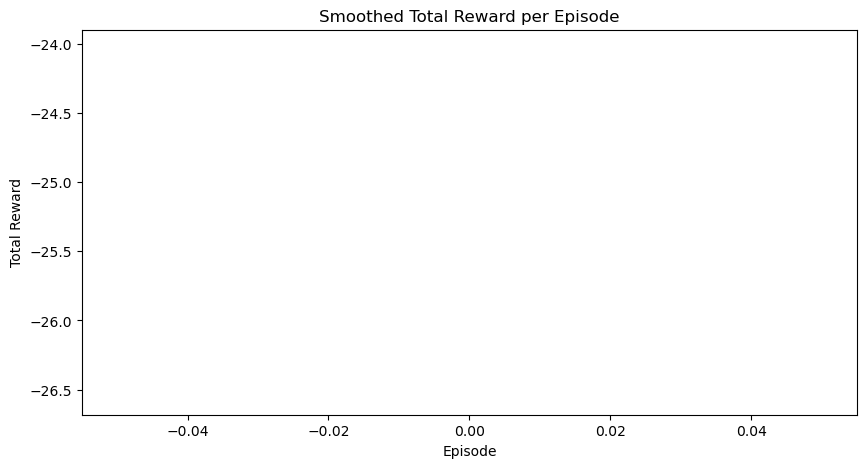

Episode 51: Reward=-37.4, ShapedReward=17634.8, Epsilon=0.70
Episode 52: Reward=-45.6, ShapedReward=-13783.4, Epsilon=0.69
Episode 53: Reward=-26.6, ShapedReward=-18253.5, Epsilon=0.69
Episode 54: Reward=-67.5, ShapedReward=-92442.1, Epsilon=0.69
Episode 55: Reward=-63.3, ShapedReward=-43336.3, Epsilon=0.68
Episode 56: Reward=-37.8, ShapedReward=47421.4, Epsilon=0.68
Episode 57: Reward=-26.8, ShapedReward=50986.7, Epsilon=0.68
Episode 58: Reward=-32.7, ShapedReward=3797.8, Epsilon=0.67
Episode 59: Reward=-76.3, ShapedReward=-134827.7, Epsilon=0.67
Episode 60: Reward=-49.4, ShapedReward=2488.8, Epsilon=0.67
Episode 61: Reward=38.6, ShapedReward=87146.7, Epsilon=0.66
Episode 62: Reward=-41.1, ShapedReward=52075.3, Epsilon=0.66
Episode 63: Reward=-13.3, ShapedReward=91471.2, Epsilon=0.66
Episode 64: Reward=-32.7, ShapedReward=25080.3, Epsilon=0.65
Episode 65: Reward=4.7, ShapedReward=107278.6, Epsilon=0.65
Episode 66: Reward=-10.8, ShapedReward=54755.8, Epsilon=0.65
Episode 67: Reward=-34

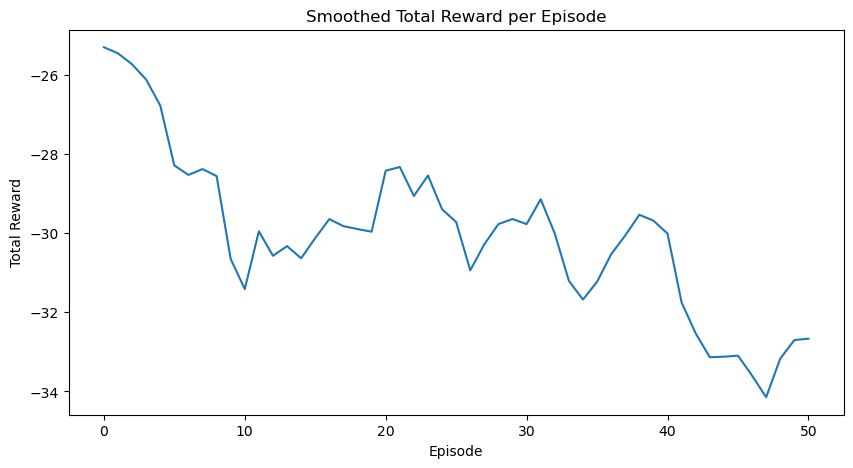

Episode 101: Reward=-22.3, ShapedReward=75193.8, Epsilon=0.54
Episode 102: Reward=-23.0, ShapedReward=15860.5, Epsilon=0.54
Episode 103: Reward=-29.9, ShapedReward=57572.5, Epsilon=0.54
Episode 104: Reward=-29.7, ShapedReward=65202.1, Epsilon=0.53
Episode 105: Reward=-81.0, ShapedReward=-113702.1, Epsilon=0.53
Episode 106: Reward=-23.3, ShapedReward=83198.1, Epsilon=0.53
Episode 107: Reward=-32.0, ShapedReward=47153.1, Epsilon=0.53
Episode 108: Reward=-57.3, ShapedReward=115016.3, Epsilon=0.52
Episode 109: Reward=5.4, ShapedReward=103139.7, Epsilon=0.52
Episode 110: Reward=-38.3, ShapedReward=43833.8, Epsilon=0.52
Episode 111: Reward=-71.2, ShapedReward=-102669.7, Epsilon=0.52
Episode 112: Reward=-16.1, ShapedReward=-87112.1, Epsilon=0.51
Episode 113: Reward=29.1, ShapedReward=94757.9, Epsilon=0.51
Episode 114: Reward=-31.7, ShapedReward=65500.4, Epsilon=0.51
Episode 115: Reward=-33.9, ShapedReward=113501.9, Epsilon=0.51
Episode 116: Reward=-20.9, ShapedReward=72907.8, Epsilon=0.50
Epi

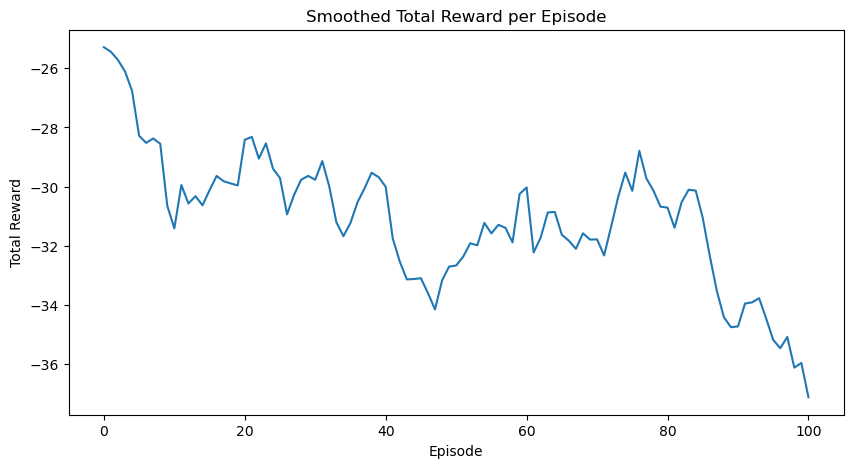

Episode 151: Reward=-33.7, ShapedReward=-68740.9, Epsilon=0.42
Episode 152: Reward=-23.8, ShapedReward=64206.8, Epsilon=0.42
Episode 153: Reward=-21.3, ShapedReward=86533.5, Epsilon=0.42
Episode 154: Reward=-46.9, ShapedReward=111024.7, Epsilon=0.42
Episode 155: Reward=-78.4, ShapedReward=-50395.1, Epsilon=0.41
Episode 156: Reward=-14.0, ShapedReward=22602.0, Epsilon=0.41
Episode 157: Reward=-71.7, ShapedReward=-3745.1, Epsilon=0.41
Episode 158: Reward=-29.6, ShapedReward=86517.1, Epsilon=0.41
Episode 159: Reward=-13.5, ShapedReward=66095.7, Epsilon=0.41
Episode 160: Reward=-25.1, ShapedReward=-16164.3, Epsilon=0.40
Episode 161: Reward=-24.4, ShapedReward=2644.0, Epsilon=0.40
Episode 162: Reward=-38.3, ShapedReward=-31630.1, Epsilon=0.40
Episode 163: Reward=-52.1, ShapedReward=28364.7, Epsilon=0.40
Episode 164: Reward=-55.9, ShapedReward=-33392.8, Epsilon=0.40
Episode 165: Reward=-34.1, ShapedReward=47832.2, Epsilon=0.39
Episode 166: Reward=-16.1, ShapedReward=80090.6, Epsilon=0.39
Epi

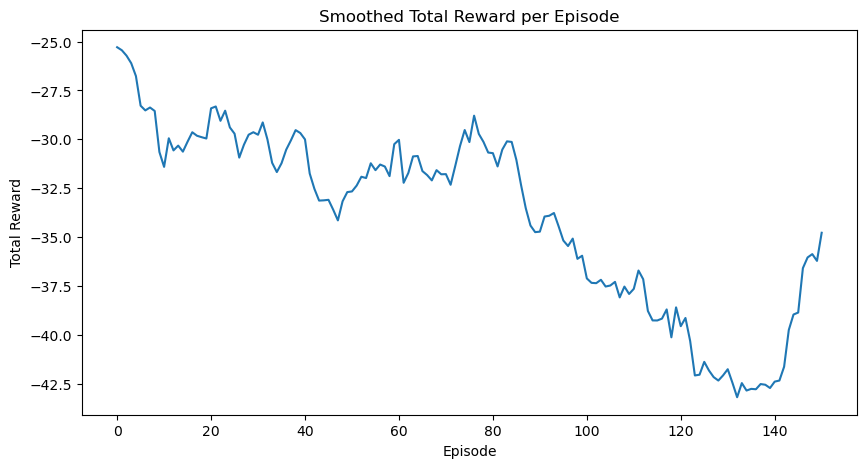

Episode 201: Reward=-34.2, ShapedReward=-98265.7, Epsilon=0.33
Episode 202: Reward=-47.4, ShapedReward=72551.0, Epsilon=0.33
Episode 203: Reward=-51.4, ShapedReward=-16738.1, Epsilon=0.33
Episode 204: Reward=-54.9, ShapedReward=55325.7, Epsilon=0.32
Episode 205: Reward=-62.2, ShapedReward=-95592.2, Epsilon=0.32
Episode 206: Reward=-19.7, ShapedReward=19938.2, Epsilon=0.32
Episode 207: Reward=-39.4, ShapedReward=20242.6, Epsilon=0.32
Episode 208: Reward=-55.3, ShapedReward=-147166.5, Epsilon=0.32
Episode 209: Reward=-24.4, ShapedReward=86348.5, Epsilon=0.32
Episode 210: Reward=-54.3, ShapedReward=-6625.7, Epsilon=0.31
Episode 211: Reward=-43.5, ShapedReward=113942.7, Epsilon=0.31
Episode 212: Reward=-17.8, ShapedReward=4203.0, Epsilon=0.31
Episode 213: Reward=-79.4, ShapedReward=-100923.5, Epsilon=0.31
Episode 214: Reward=-81.6, ShapedReward=-146410.7, Epsilon=0.31
Episode 215: Reward=-9.2, ShapedReward=75895.2, Epsilon=0.31
Episode 216: Reward=-36.7, ShapedReward=56039.3, Epsilon=0.30


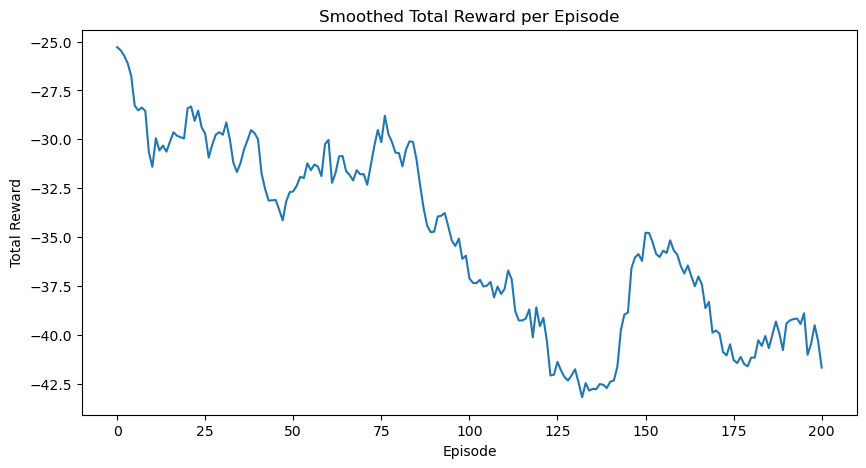

Episode 251: Reward=-56.5, ShapedReward=113825.6, Epsilon=0.26
Episode 252: Reward=-49.4, ShapedReward=113516.9, Epsilon=0.25
Episode 253: Reward=-17.3, ShapedReward=-6040.5, Epsilon=0.25
Episode 254: Reward=-21.5, ShapedReward=48398.7, Epsilon=0.25
Episode 255: Reward=-88.4, ShapedReward=-165274.0, Epsilon=0.25
Episode 256: Reward=-78.1, ShapedReward=-127360.5, Epsilon=0.25
Episode 257: Reward=-41.2, ShapedReward=17273.5, Epsilon=0.25
Episode 258: Reward=-24.8, ShapedReward=15311.4, Epsilon=0.25
Episode 259: Reward=-32.1, ShapedReward=46766.6, Epsilon=0.25
Episode 260: Reward=-17.8, ShapedReward=4649.3, Epsilon=0.24
Episode 261: Reward=-82.6, ShapedReward=-162186.5, Epsilon=0.24
Episode 262: Reward=-85.0, ShapedReward=-147012.6, Epsilon=0.24
Episode 263: Reward=-55.9, ShapedReward=8655.5, Epsilon=0.24
Episode 264: Reward=-61.2, ShapedReward=111958.6, Epsilon=0.24
Episode 265: Reward=8.9, ShapedReward=20334.5, Epsilon=0.24
Episode 266: Reward=-54.4, ShapedReward=-36772.1, Epsilon=0.24


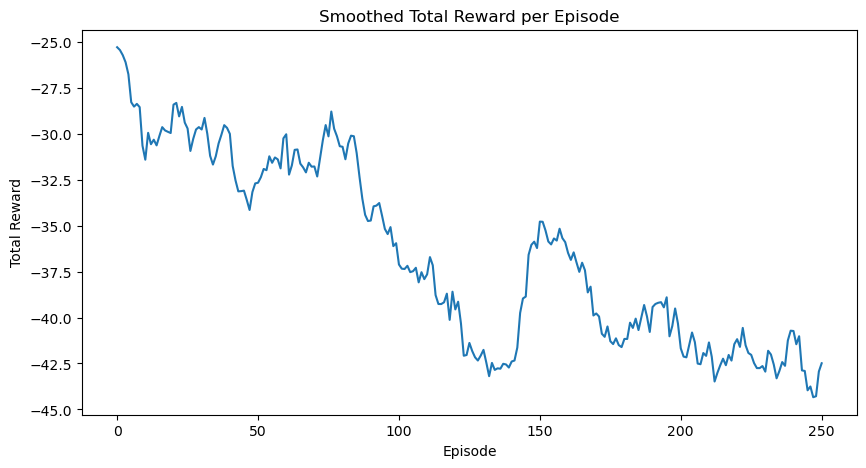

Episode 301: Reward=-38.6, ShapedReward=79841.4, Epsilon=0.20
Episode 302: Reward=-53.8, ShapedReward=-53267.8, Epsilon=0.20
Episode 303: Reward=-85.1, ShapedReward=-161688.8, Epsilon=0.20
Episode 304: Reward=-15.7, ShapedReward=43411.9, Epsilon=0.20
Episode 305: Reward=18.2, ShapedReward=110912.1, Epsilon=0.20
Episode 306: Reward=-46.1, ShapedReward=31858.9, Epsilon=0.19
Episode 307: Reward=-40.8, ShapedReward=-117610.0, Epsilon=0.19
Episode 308: Reward=-29.5, ShapedReward=64932.3, Epsilon=0.19
Episode 309: Reward=3.6, ShapedReward=60211.8, Epsilon=0.19
Episode 310: Reward=5.7, ShapedReward=46306.7, Epsilon=0.19
Episode 311: Reward=5.8, ShapedReward=89731.5, Epsilon=0.19
Episode 312: Reward=-62.5, ShapedReward=115523.3, Epsilon=0.19
Episode 313: Reward=-87.8, ShapedReward=-107708.4, Epsilon=0.19
Episode 314: Reward=-68.0, ShapedReward=-5468.0, Epsilon=0.19
Episode 315: Reward=-39.8, ShapedReward=10777.1, Epsilon=0.19
Episode 316: Reward=15.5, ShapedReward=28867.7, Epsilon=0.18
Episode

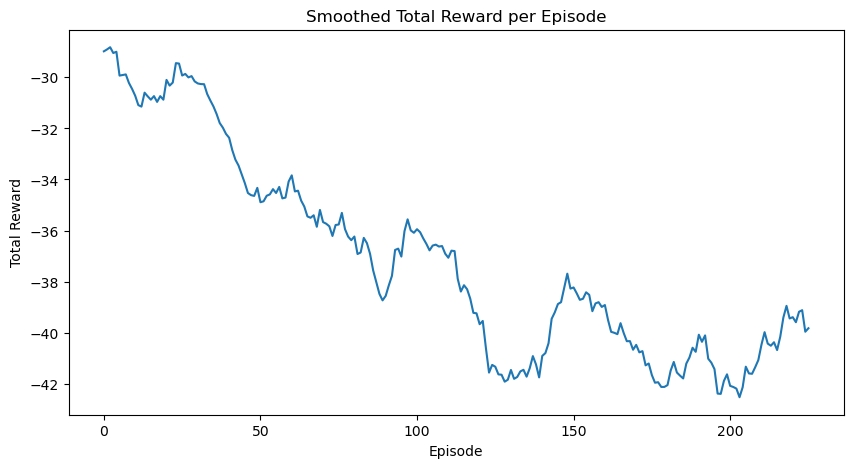

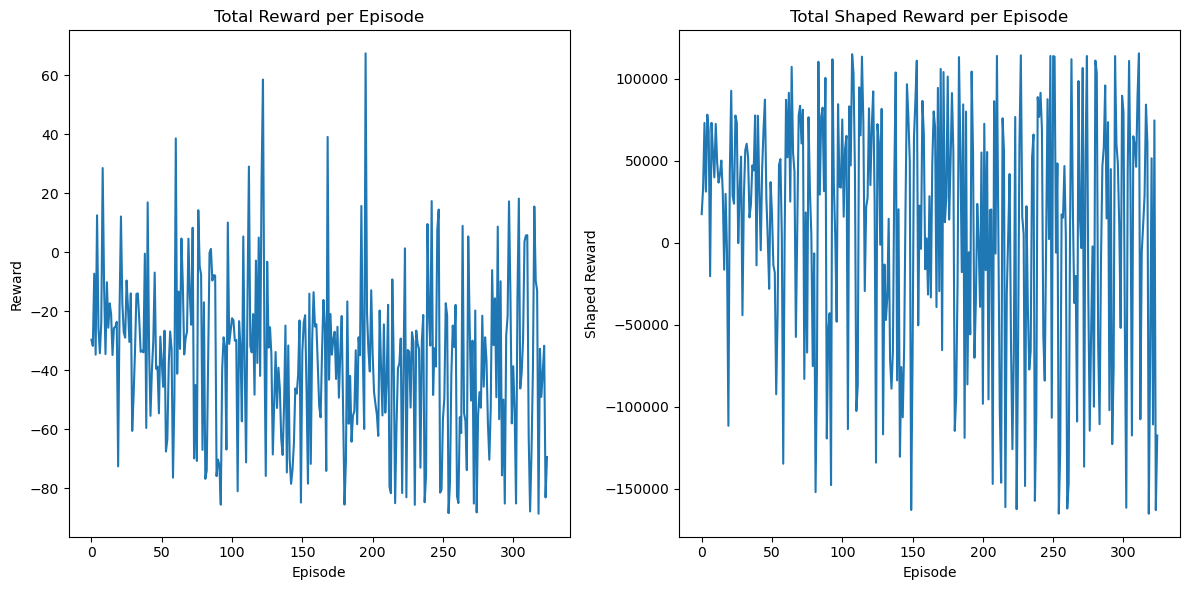

In [28]:
import numpy as np
import cv2
import gymnasium as gym
import pygame
import datetime
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import warnings
import os

# Enhanced action space with progressive controls
# [-1 to 1 is left to right steering, gas, brake]
ACTIONS = [np.array(x) for x in [
    [0.0, 0.0, 0.0],     # No Action
    [-1.0, 2, 0.0],     # Turn left hard & accelerate hard
    [-0.5, 1.2, 0.0],     # Turn left soft & accelerate soft
    [-1.0, 1.2, 0.4],     # Turn left hard & accelerate soft
    [-1.0, 0.2, 0.4],     # Turn left hard & brake
    [-0.5, 0.2, 0.4],     # Turn left soft & brake
    [0.0, 2.3, 0.0],      # No turn & accelerate fast
    [0.0, 2.0, 0.0],      # No turn & accelerate hard
    [0.0, 1.0, 0.0],      # No turn & accelerate soft
    [1.0, 1.2, 0.0],      # Turn right hard & accelerate hard
    [1.0, 1, 0.8],      # Turn right hard & accelerate soft
    [1.0, 0.3, 0.4],      # Turn right hard & brake
    [0.5, 0.3, 0.4],       # Turn right soft & brake
    [0, 0, 2.0],       # No turn & brake hard
]]

NO_ACTION = ACTIONS[0]

class CarRacingQL:
    def __init__(self, episodes=500, state_bins=None, epsilon=0.9,
                 alpha=0.1, gamma=0.9, render=True, save_path="q_table.npy", record_video=False, video_dir="videos"):
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        self.env = gym.make('CarRacing-v3', continuous=True, render_mode='rgb_array')
        self.record_video = record_video  # Store if we should record
        self.video_dir = video_dir
        if record_video:
            self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_dir,
                                                episode_trigger=lambda x: x % 50 == 0)  # Record every 50th
        self.actions = list(range(len(ACTIONS)))
        self.epsilon = epsilon
        self.base_alpha = alpha
        self.base_gamma = gamma
        self.episodes = episodes
        self.render = render
        self.time_off_track = None
        self.prev_center_offset = 0.0
        self.save_path = save_path

        self.state_bins = [
            np.linspace(-1.0, 1.0, 10),  # Center offset (normalized -1 to 1)
            np.linspace(0, 1.5, 5),  # Speed (normalized 0 to 1.5)
            [0.0, 1.0],  # Off-track (binary)
            np.linspace(-1.0, 1.0, 5)  # Future curve (normalized -1 to 1)
        ]

        state_space_size = tuple(len(bins) + 1 for bins in self.state_bins)  # Add 1 because np.digitize can return len(bins)
        self.Q_table = np.zeros(state_space_size + (len(self.actions),))  # Add action dimension
        self.screen = None
        self.road_curve_frequency = 0.3  # Curriculum parameter
        self.episode_count = 0  # Keep track of episodes
        self.temp_dir = None # To store temp video dir

    def process_vision(self, obs):
        """Enhanced vision processing with future horizon analysis"""
        future_curve = 0.0
        steer_bias = 0.0
        upper_region = obs[:int(obs.shape[0] * 0.4), :, :]
        gray_upper = cv2.cvtColor(upper_region, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray_upper, (5, 5), 0)
        edges_upper = cv2.Canny(blurred, 50, 150)

        lines = cv2.HoughLinesP(edges_upper, 1, np.pi / 180, 25,
                                 minLineLength=20, maxLineGap=10)
        angles = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                angle = np.arctan2(y2 - y1, x2 - x1) / np.pi
                angles.append(angle)

        future_curve = np.clip(np.mean(angles) if angles else 0.0, -1, 1)

        lower_region = obs[int(obs.shape[0] * 0.6):, :, :]
        gray_lower = cv2.cvtColor(lower_region, cv2.COLOR_RGB2GRAY)
        edges_lower = cv2.Canny(gray_lower, 50, 150)

        left_edge = edges_lower[:, :edges_lower.shape[1] // 2].mean()
        right_edge = edges_lower[:, edges_lower.shape[1] // 2:].mean()
        steer_bias = np.clip((right_edge - left_edge) / 255.0, -1, 1)

        return future_curve, steer_bias

    def render_frame(self, obs, video_frame=None): 
        new_width = 800
        new_height = 600

        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((new_width, new_height))
            pygame.display.set_caption("CarRacing Q-Learning with Debug")
            self.debug_surface = pygame.Surface((new_width, new_height))

        cropped = obs[:int(obs.shape[0] * 0.88), :, :]
        surf = pygame.surfarray.make_surface(cropped.swapaxes(0, 1))
        scaled_surf = pygame.transform.scale(surf, (new_width, int(new_height * 0.7)))

        self.screen.blit(scaled_surf, (0, 0))

        # --- Visualization of center offset calculation ---
        debug_area_height = int(new_height * 0.3)
        debug_y_offset = int(new_height * 0.7)
        self.debug_surface.fill((50, 50, 50))

        if hasattr(self, 'debug_mask') and hasattr(self, 'debug_roi_rgb'):
            resized_roi = cv2.resize(self.debug_roi_rgb, (int(new_width * 0.4), debug_area_height // 2))
            resized_mask = cv2.cvtColor(cv2.resize(self.debug_mask, (int(new_width * 0.4), debug_area_height // 2)),
                                         cv2.COLOR_GRAY2RGB)

            pygame_roi = pygame.surfarray.make_surface(resized_roi.swapaxes(0, 1))
            pygame_mask = pygame.surfarray.make_surface(resized_mask.swapaxes(0, 1))

            self.debug_surface.blit(pygame_roi, (20, 20))
            self.debug_surface.blit(pygame_mask, (20, 20 + debug_area_height // 2 + 10))

            if hasattr(self, 'debug_track_center') and self.debug_track_center is not None:
                center_x_scaled = int(self.debug_track_center[0] * (new_width * 0.4) / self.debug_roi_rgb.shape[1]) + 20
                center_y_scaled = debug_area_height // 4 + 20
                pygame.draw.circle(self.debug_surface, (255, 0, 0), (center_x_scaled, center_y_scaled), 5)

                pygame.draw.line(self.debug_surface, (0, 255, 0),
                                 (int(new_width * 0.4) // 2 + 20, 20),
                                 (int(new_width * 0.4) // 2 + 20, 20 + debug_area_height // 2), 2)

                if hasattr(self, 'last_offset'):
                    font = pygame.font.Font(None, 30)
                    text_surface_offset = font.render(f"Offset: {self.last_offset:.2f}", True, (255, 255, 255))
                    self.debug_surface.blit(text_surface_offset, (int(new_width * 0.5), 30))
            if hasattr(self, 'debug_speed'):
                text_surface_speed = font.render(f"Speed: {self.debug_speed:.2f}", True, (255, 255, 255))
                self.debug_surface.blit(text_surface_speed, (int(new_width * 0.5), 70))

            # Display the future curve
            if hasattr(self, 'debug_future_curve'):
                text_surface_future_curve = font.render(f"Curve: {self.debug_future_curve:.2f}", True, (255, 255, 255))
                self.debug_surface.blit(text_surface_future_curve, (int(new_width * 0.5), 110))

        self.screen.blit(self.debug_surface, (0, debug_y_offset))

        # --- Display the recorded video frame ---
        # if video_frame is not None:
        #     video_surf = pygame.surfarray.make_surface(video_frame.swapaxes(0, 1))
        #     scaled_video_surf = pygame.transform.scale(video_surf, (new_width // 2, new_height // 2))  # Adjust size as needed
        #     self.screen.blit(scaled_video_surf, (new_width // 4, new_height // 4))  # Center the video

        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                self.screen = None

    def skip_frames(self, skip=50):
        obs, _ = self.env.reset()
        for _ in range(skip):
            obs, _, terminated, truncated, _ = self.env.step(NO_ACTION)
            if terminated or truncated:
                return obs, True
        return obs, False

    def compute_center_offset(self, obs):
        height, width = obs.shape[0], obs.shape[1]
        roi = obs[int(height * 0.7):, :]

        hsv = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
        lower_track = np.array([0, 0, 40])
        upper_track = np.array([180, 50, 160])
        mask = cv2.inRange(hsv, lower_track, upper_track)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            return 1.0

        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] == 0:
            return 1.0

        track_center_x = moments["m10"] / moments["m00"]
        offset = (track_center_x - width / 2) / (width / 2)

        if hasattr(self, 'last_offset'):
            offset = 0.7 * offset + 0.3 * self.last_offset
        self.last_offset = offset

        self.debug_mask = mask.copy()
        self.debug_roi_rgb = cv2.cvtColor(roi, cv2.COLOR_HSV2RGB)
        if largest_contour is not None and moments["m00"] > 0:
            self.debug_track_center = (int(track_center_x), roi.shape[0] // 2)
        else:
            self.debug_track_center = None

        return np.clip(offset, -1.0, 1.0)

    def is_off_track(self, obs):
        track_pixels = obs[:, :, :3]
        on_track_threshold = 0.3
        track_like_pixels = np.sum((track_pixels > 100), axis=2) == 3
        on_track_ratio = np.mean(track_like_pixels)
        return on_track_ratio < on_track_threshold

    def extract_features(self, obs, history):
        """Enhanced feature extraction with temporal awareness"""
        car = self.env.unwrapped.car
        vel = car.hull.linearVelocity
        speed = np.sqrt(vel.x ** 2 + vel.y ** 2)

        future_curve, steer_bias = self.process_vision(obs)
        center_offset = self.compute_center_offset(obs)
        lateral_trend = center_offset - self.prev_center_offset
        self.prev_center_offset = center_offset

        speed_history = history['speed']
        speed_history.append(speed)
        accel_trend = (speed_history[-1] - speed_history[-3]) / 2.0 if len(speed_history) >= 3 else 0.0

        off_track = 1.0 if self.is_off_track(obs) else 0.0
        if off_track == 1.0:
            if self.time_off_track is None:
                self.time_off_track = datetime.datetime.now()
        else:  
            self.time_off_track = None

        steering_angle = car.wheels[0].steer
        angular_momentum = speed * steering_angle

        self.debug_speed = speed
        self.debug_future_curve = future_curve

        return [
            np.clip(center_offset, -1, 1),
            np.clip(speed / 100.0, 0, 1.5),
            off_track,
            np.clip(future_curve, -1, 1)
        ]

    
    def shape_reward(self, env_reward, features, next_features, action):
        on_track_bonus = 125.0 * (next_features[2])
        off_track_penalty = 200.0 * (1 - next_features[2])
        center_penalty = abs(next_features[0]) * 350.0
        speed_penalty = 0.0
        reward = 0
        if features[1] > 0.9:  # If speed is above a threshold
            if features[1] > 1.2:
                speed_penalty = 0.5 * (features[1] - 1.2) * 100.0
            else:
                reward += 0.5 * (features[1] - 0.9) * 100.0
            

        # Calculate the total reward
        reward += env_reward + on_track_bonus - off_track_penalty - center_penalty + speed_penalty

        if self.time_off_track:
                time_off_track_duration = (datetime.datetime.now() - self.time_off_track).total_seconds()
                if time_off_track_duration > 1.0:
                    reward -= 100.0
                    self.time_off_track = None
        return reward


    def discretize_state(self, features):
        return tuple(
            np.digitize(f, b) - 1
            for f, b in zip(features, self.state_bins)
        )

    def adaptive_parameters(self, features):
        """Dynamic learning parameters based on situation"""
        alpha = self.base_alpha
        gamma = self.base_gamma
        if abs(features[0]) > 0.6:  # Near edge
            alpha *= 1.5
            gamma *= 0.95
        elif abs(features[3]) > 0.5:  # Sharp curve ahead
            alpha *= 1.2
            gamma *= 0.9
        return np.clip(alpha, 0.01, 1.0), np.clip(gamma, 0.1, 1.0)

    def run_episode(self, episode_num):
        obs, done = self.skip_frames(50)
        history = {
            'speed': deque(maxlen=5),
            'steer': deque(maxlen=3)
        }
        total_reward = 0
        total_shaped_reward = 0
        self.episode_count += 1  # Increment episode counter
        video_frame = None # Initialize

        features = self.extract_features(obs, history)
        state = self.discretize_state(features)
        step = 1
        while not done:
            alpha, gamma = self.adaptive_parameters(features)

            if np.random.random() < self.epsilon:
                action_idx = np.random.choice(len(self.actions))
            else:
                action_idx = np.argmax(self.Q_table[state])

            action = ACTIONS[action_idx]
            next_obs, reward, terminated, truncated, _ = self.env.step(action) # Get info
            done = terminated or truncated

            next_features = self.extract_features(next_obs, history)
            next_state = self.discretize_state(next_features)

            shaped_reward = self.shape_reward(reward, features, next_features, action)
           
            total_reward += reward
            total_shaped_reward += shaped_reward

            max_future_q = np.max(self.Q_table[next_state])
            self.Q_table[state][action_idx] += alpha * (
                shaped_reward + gamma * max_future_q - self.Q_table[state][action_idx]
            )

            state = next_state
            features = next_features

            if done or truncated:
                break

            if self.render:
                debug_obs = next_obs.copy()
                self.render_frame(debug_obs, video_frame) # Pass frame
                if self.record_video:
                    video_frame = debug_obs.copy() # Capture frame for video display
            step += 1
        return total_reward, total_shaped_reward

    def train(self):
        rewards = []
        shaped_rewards = []
        try:
            for episode in range(1, self.episodes + 1):
                reward, shaped_reward = self.run_episode(episode)
                rewards.append(reward)
                shaped_rewards.append(shaped_reward)
                self.epsilon = max(0.01, self.epsilon * 0.995)
                print(
                    f"Episode {episode}: Reward={reward:.1f}, ShapedReward={shaped_reward:.1f}, Epsilon={self.epsilon:.2f}")

                if episode % 50 == 0:
                    plot_rewards(rewards, smoothing_window=50, save_path="plots_tabular")

        except Exception as e:
            print(f"An error occurred during training: {e}")
            self.env.close()  # Ensure env is closed on error
            if self.render and self.screen is not None:
                pygame.quit()
            raise 
        
        plot_rewards(rewards, smoothing_window=100, save_path="plots_tabular")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(rewards)
        plt.title("Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        plt.subplot(1, 2, 2)
        plt.plot(shaped_rewards)
        plt.title("Total Shaped Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Shaped Reward")

        plt.tight_layout()
        plt.show()

def plot_rewards(rewards, smoothing_window=375, save_path="plots_tabular"):
    os.makedirs(save_path, exist_ok=True)
    smoothed = np.convolve(rewards, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed)
    plt.title("Smoothed Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"{save_path}/smoothed_rewards_{timestamp}.png")
    plt.show()

if __name__ == "__main__":
    agent = CarRacingQL(episodes=325, render=True, record_video=False, video_dir="videos")
    agent.train()